In [83]:
"""
This code builds a LSTM model to predict the data transferred 2 seconds in the future, using data captured as bandwidth is increased.

1. Data Preparation: The dataset containing historical throughput and transferred data is prepared.

2. LSTM Model: A Long Short-Term Memory (LSTM) model is constructed to learn the patterns and trends in the throughput and transferred data.
   The model is trained on the historical data to predict future bandwidth values.

3. PID Integration: After training the LSTM model, a Proportional-Integral-Derivative (PID) controller is integrated into the prediction pipeline.
   The PID controller fine-tunes the predictions produced by the LSTM model to match the actual data transferred.

4. Demonstration: The combined LSTM-PID model is evaluated by comparing its predictions with the actual data transferred.
   This demonstrates how incorporating a PID controller can improve the accuracy of the LSTM model's predictions and better match the actual outputs.
"""


"\nThis code builds a LSTM model to predict the data transferred per second in the future, using data captured as bandwidth is increased.\n\n1. Data Preparation: The dataset containing historical throughput and transferred data is prepared.\n\n2. LSTM Model: A Long Short-Term Memory (LSTM) model is constructed to learn the patterns and trends in the throughput and transferred data.\n   The model is trained on the historical data to predict future bandwidth values.\n\n3. PID Integration: After training the LSTM model, a Proportional-Integral-Derivative (PID) controller is integrated into the prediction pipeline.\n   The PID controller fine-tunes the predictions produced by the LSTM model to match the actual data transferred.\n\n4. Demonstration: The combined LSTM-PID model is evaluated by comparing its predictions with the actual data transferred.\n   This demonstrates how incorporating a PID controller can improve the accuracy of the LSTM model's predictions and better match the actual

In [84]:
# Importing necessary libraries
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)

In [85]:
# Mounting Google Drive to access files
drive.mount('/content/gdrive')
Increasing_BW_data = pd.read_fwf('/content/gdrive/My Drive/Data/Data_with_BW_Increasing/Increasing_BW.txt')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Steps below are performing some data_preprocessing

In [86]:
datasets = [Increasing_BW_data]

In [87]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [88]:
# Dropping off irrelevant columns and only keeping the relevant
data_frames = [Increasing_BW_data]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [89]:
df['increment'] = range(len(Increasing_BW_data))

In [90]:
# Dividing 'Transfer' column values by 1024 for data conversion to MBytes
Increasing_BW_data.loc[0:38, 'Transfer'] /= 1024

In [91]:
# Multiplying 'Bandwidth' column values by 1000 where the value is less than 5 to make uniformity of MBytes/Sec
Increasing_BW_data.loc[Increasing_BW_data['Bandwidth'] < 5, 'Bandwidth'] *= 1000

In [92]:
# Dropping off outlier points
Increasing_BW_data.drop([1159, 3980], inplace=True)

# Visualizing the data we shall make predictions on

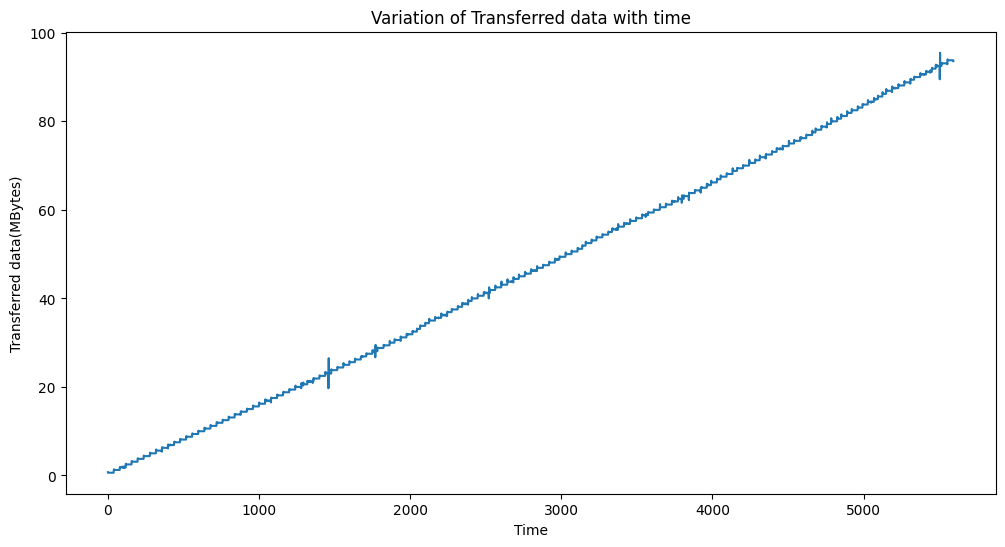

In [93]:
import seaborn as sns
# Creating a plot to visualize the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='increment', y='Transfer', data=Increasing_BW_data)
plt.xlabel('Time')
plt.ylabel('Transferred data(MBytes)')
plt.title('Variation of Transferred data with time')
plt.show()

In [94]:
# Checking the shape of the Data'
Increasing_BW_data.shape

(5593, 3)

# Perfoming data splitting (Training_set, Validation_set, Test_set)

In [95]:
# Defining train_size as 70% of the length of the data
train_size = int(0.7 * len(Increasing_BW_data))
# Creating the train_set by selecting the first 70% of the data
train_set = Increasing_BW_data[:train_size]

In [96]:
# Defining validation_size as 15% of the length of the data
val_size = int(0.15 * len(Increasing_BW_data))
# Creating the val_set by selecting the first 15% of the data
val_set = Increasing_BW_data[train_size:train_size + val_size]

In [97]:
# Creating the test_set by selecting the data after the train_set and val_set
test_set = Increasing_BW_data[train_size + val_size:]

In [98]:
# Concatenating train_set and val_set to create train_all_data
train_all = pd.concat([train_set, val_set], axis=0)

In [99]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transferred Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth', 'Transfer']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# trainining  and validation data
train_values = np.asarray(feature_matrix(train_set,features),dtype=np.float32)
train_labels = np.asarray(train_set['Transfer'],dtype=np.float32)

val_values = np.asarray(feature_matrix(val_set,features),dtype=np.float32)
val_labels = np.asarray(val_set['Transfer'],dtype=np.float32)

# train_all_data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_all['Transfer'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(test_set,features),dtype=np.float32)
test_labels = np.asarray(test_set['Transfer'],dtype=np.float32)



# checking
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)

(3915, 2)
(3915,)
(838, 2)
(838,)
(4753, 2)
(4753,)
(840, 2)
(840,)


In [100]:
# Creating a MinMaxScaler instance SS1 and fitting it to train_values
SS1 = MinMaxScaler()
SS1.fit(train_values)

# Transforming train_values and val_values using SS1
train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# Creating another MinMaxScaler instance SS2 and fitting it to train_all_values
SS2 = MinMaxScaler()
SS2.fit(train_all_values)

# Transforming train_all_values and test_values using SS2
train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

# Setting the desired WINDOW_SIZE (how much we go back in the past)

In [101]:
WINDOW_SIZE = 1

In [102]:
# Function to create our windowed dataset with ahead set to 4 = 2 seconds
def create_dataset_windowed(features, labels, ahead=4, window_size=WINDOW_SIZE, max_window_size=200):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]

**Creating the windowed data_sets for training**

In [103]:
# Creating windowed datasets for training and validation sets
X_train_dense, r_train_dense = create_dataset_windowed(train_scaled, train_labels)
X_val_dense, r_val_dense = create_dataset_windowed(val_scaled, val_labels)

# Printing shapes of the created datasets
print(X_train_dense.shape)
print(r_train_dense.shape)
print(X_val_dense.shape)
print(r_val_dense.shape)


(3712, 1, 2)
(3712,)
(635, 1, 2)
(635,)


# First training the model on the training and validation sets

In [104]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularization
wreg = L1L2(l1=0.001, l2=0.01)

LSTMmodel = Sequential()

# Adding layers to the model
LSTMmodel.add(Dense(32, input_shape=(WINDOW_SIZE,2), activation='relu'))
LSTMmodel.add(LSTM(input_shape = (WINDOW_SIZE,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTMmodel.add(Dense(16,activation='relu'))
LSTMmodel.add(Dense(8,activation='relu'))
LSTMmodel.add(Dense(4,activation='relu'))
LSTMmodel.add(Dense(1))
LSTMmodel.summary()

LSTMmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=16
epochs=40

# Training the model
LSTMhistory = LSTMmodel.fit(X_train_dense, r_train_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_dense, r_val_dense),
          shuffle=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1, 32)             96        
                                                                 
 lstm_6 (LSTM)               (None, 256)               295936    
                                                                 
 dense_31 (Dense)            (None, 16)                4112      
                                                                 
 dense_32 (Dense)            (None, 8)                 136       
                                                                 
 dense_33 (Dense)            (None, 4)                 36        
                                                                 
 dense_34 (Dense)            (None, 1)                 5         
                                                                 
Total params: 300321 (1.15 MB)
Trainable params: 30032

In [105]:
# Plotting the history of Mean Absolute Error for training and validation sets
def plot_history(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

# Plotting the training and validation loss curves

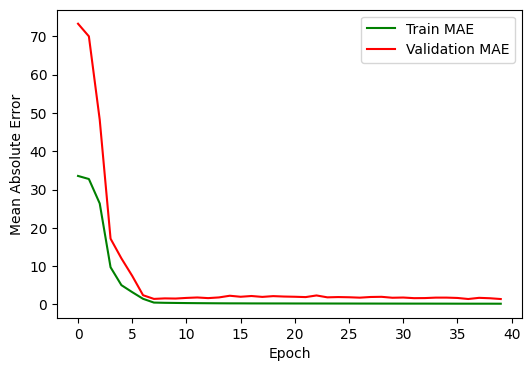

In [106]:
plot_history(LSTMhistory)


# Combining the training set and the validation set to create a larger training dataset.Trainining the model on this combined dataset to utilize all available data.Performing validation on the final test set to assess the model's performance on unseen data.



In [108]:
# Creating a windowed data_set
X_train_all_dense,r_train_all_dense = create_dataset_windowed(train_all_scaled,train_all_labels)
X_test_dense,r_test_dense = create_dataset_windowed(test_scaled,test_labels)

print(X_train_all_dense.shape)
print(r_train_all_dense.shape)
print(X_test_dense.shape)
print(r_test_dense.shape)

(4550, 1, 2)
(4550,)
(637, 1, 2)
(637,)


# Training the model on the whole training set (train + validation sets) and evaluating it on the test set.

In [109]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer  to 256
HIDDEN_RNN = 256
# applying regularization
wreg = L1L2(l1=0.001, l2=0.01)

LSTM_model = Sequential()

# Adding layers to the model
LSTM_model.add(Dense(32, input_shape=(WINDOW_SIZE,2), activation='relu'))
LSTM_model.add(LSTM(input_shape = (WINDOW_SIZE,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTM_model.add(Dense(16,activation='relu'))
LSTM_model.add(Dense(8,activation='relu'))
LSTM_model.add(Dense(4,activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.summary()

LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=16
epochs=40

# Training the model
LSTM_history = LSTM_model.fit(X_train_all_dense, r_train_all_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_dense, r_test_dense),
          shuffle=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 1, 32)             96        
                                                                 
 lstm_7 (LSTM)               (None, 256)               295936    
                                                                 
 dense_36 (Dense)            (None, 16)                4112      
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 4)                 36        
                                                                 
 dense_39 (Dense)            (None, 1)                 5         
                                                                 
Total params: 300321 (1.15 MB)
Trainable params: 30032

In [110]:
# Plotting the history of Mean Absolute Error for training_all_dataset and test sets
def plot_history_test(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train_all MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Test MAE')
  plt.legend()
  plt.show()

# Plotting the model loss curves

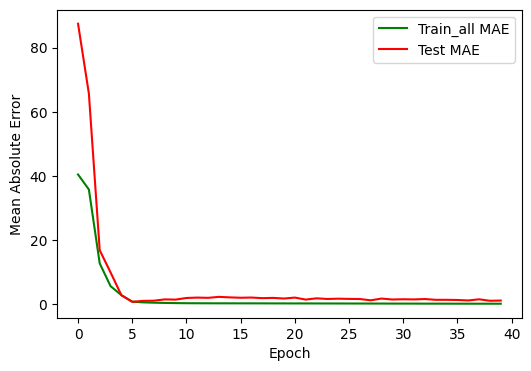

In [111]:
plot_history_test(LSTM_history)

# Calculating the average Mean Absolute Error on the test_set

In [112]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_all_LSTM = LSTM_model.predict(X_train_all_dense)
y_test_LSTM = LSTM_model.predict(X_test_dense)

# Calculating the mean absolute error from the training_all_dataset and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_dense, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_dense, y_test_LSTM)

# Printing the mean absolute error from the training_all_dataeet and test sets
print("\ train_all mae = ", mae_train_all_LSTM,
      "\n Test mae = ", mae_test_LSTM)

# Checking the shapes of the predicted output from the training_all_dataset and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

20/20 [==============================] - 0s 3ms/step
\ train_all mae =  0.1626981 
 Test mae =  1.1597979
(4550, 1)
(637, 1)


# **PID Integration**
Here I integrate the PID which uses what the model predicts and what the actual transferred data is to give a better output

In [113]:
# Initializing the PID controller
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        """
        Parameters:
        - Kp (float): Proportional gain coefficient.
        - Ki (float): Integral gain coefficient.
        - Kd (float): Derivative gain coefficient.
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0 # Previous error initialized to zero
        self.integral = 0 # Integral term initialized to zero

    def compute_control_signal(self, error):
        """
        Computing the control signal based on the current error.

        Parameters:
        - error (float): The current error signal.

        Returns:
        - control_signal (float): The computed control signal.
        """
        self.integral += error
        derivative = error - self.prev_error
        self.prev_error = error
        control_signal = self.Kp * error + self.Ki * self.integral + self.Kd * derivative # Computing the control signal using PID formula
        return control_signal

# Defining PID parameters
Kp = 0.1
Ki = 0.001
Kd = 0.1

# Initializing the PID controller
pid_controller = PIDController(Kp, Ki, Kd)

# Setting reference values
reference_train = r_train_all_dense
reference_test = r_test_dense

# Initializing PID control signals
control_signal_train = 0
control_signal_test = 0

y_train_all_LSTM_new = []
y_test_LSTM_new = []

# PID control loop
for i in range(len(X_train_all_dense)):
    error_train = reference_train[i] - y_train_all_LSTM[i]
    control_signal_train = pid_controller.compute_control_signal(error_train)
    # Applying control signal to model output
    y_train_all_LSTM_new.append(y_train_all_LSTM[i] + control_signal_train)

for i in range(len(X_test_dense)):
    error_test = reference_test[i] - y_test_LSTM[i]
    control_signal_test = pid_controller.compute_control_signal(error_test)
    # Applying control signal to model output
    y_test_LSTM_new.append(y_test_LSTM[i] + control_signal_test)


# PID Mean Absolute Error
mae_train_all_LSTM_new = mean_absolute_error(reference_train, y_train_all_LSTM_new)
mae_test_LSTM_new = mean_absolute_error(reference_test, y_test_LSTM_new)

# printing MAE results for comparison
print(f"Old MAE for train: {mae_train_all_LSTM}")
print(f"Old MAE for test: {mae_test_LSTM}")
print(f"New(PID) MAE for train: {mae_train_all_LSTM_new}")
print(f"New(PID) MAE for test: {mae_test_LSTM_new}")


Old MAE for train: 0.16269810497760773
Old MAE for test: 1.1597979068756104
New(PID) MAE for train: 0.17587794363498688
New(PID) MAE for test: 0.502153217792511


# Plotting the predictions

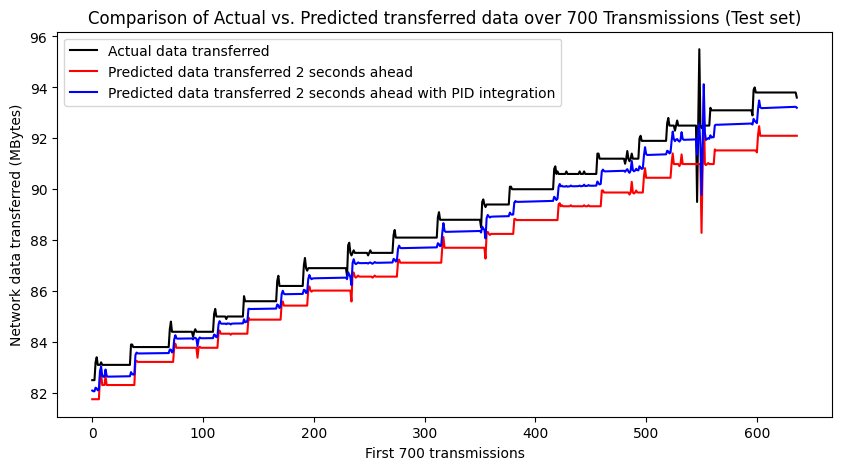

In [118]:
# Now plotting the labels and scaled predictions
plt.figure(figsize=(10, 5))
plt.plot(r_test_dense[:700], 'k-', label='Actual data transferred')
plt.plot(y_test_LSTM[:700], 'r-', label='Predicted data transferred 2 seconds ahead')
plt.plot(y_test_LSTM_new[:700], 'b-', label='Predicted data transferred 2 seconds ahead with PID integration')
plt.ylabel('Network data transferred (MBytes)')
plt.xlabel('First 700 transmissions')
plt.title('Comparison of Actual vs. Predicted transferred data over 700 Transmissions (Test set)')
plt.legend()
plt.show()

# Displaying a table for the plotted predictions for visualization

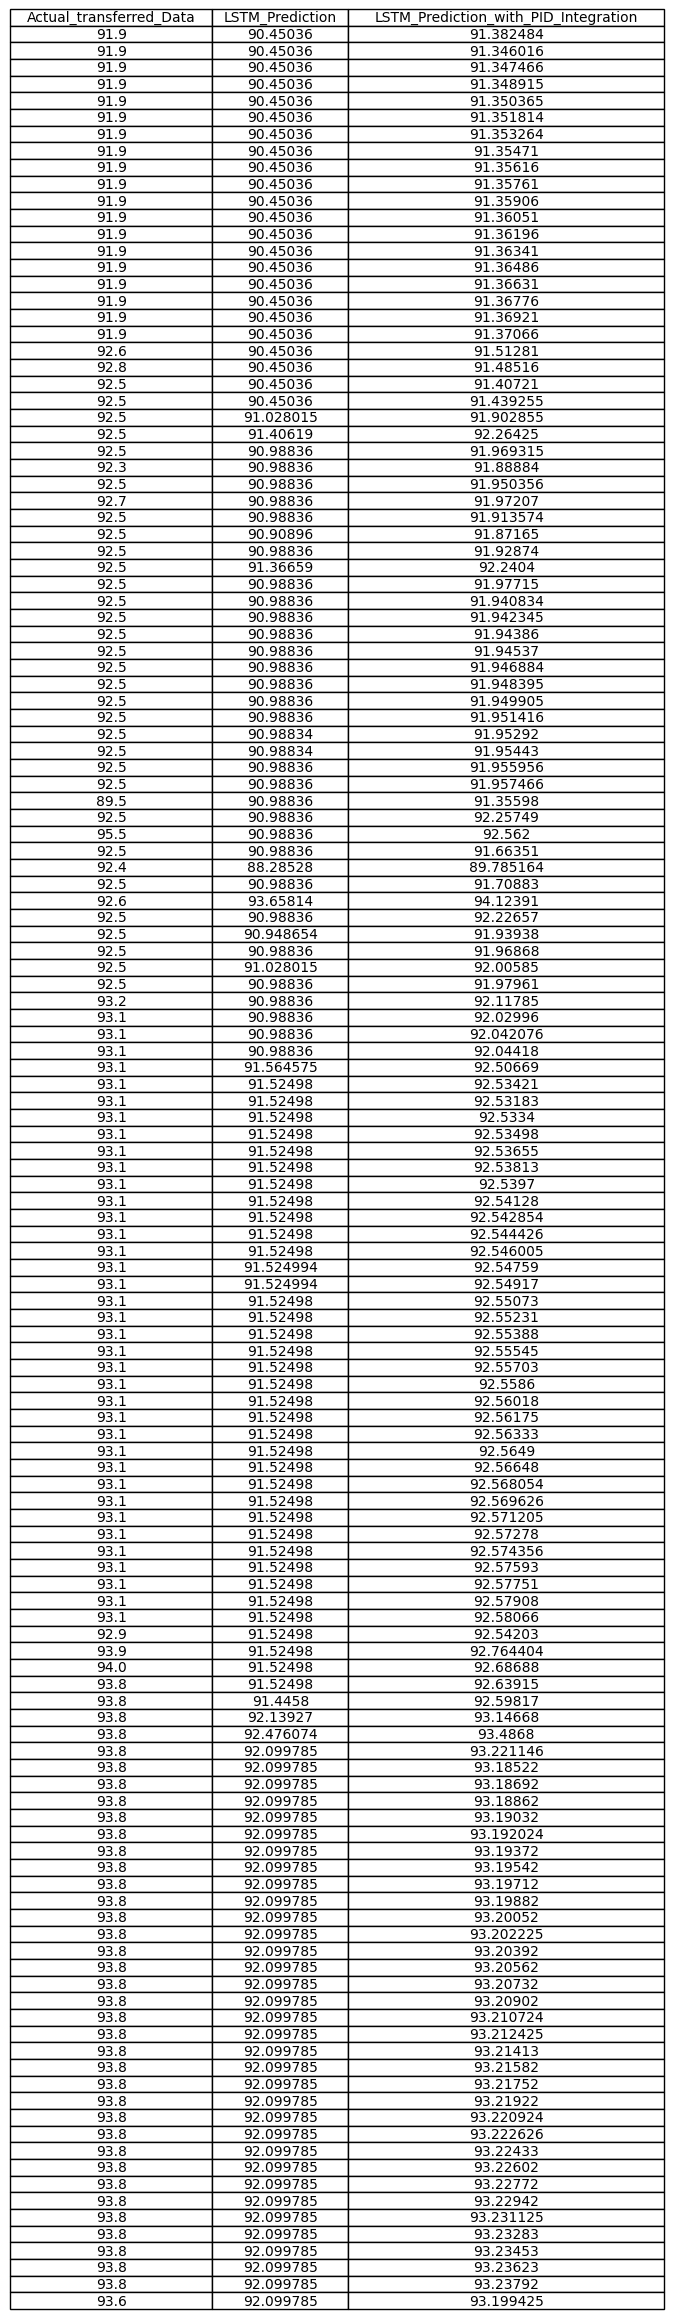

In [115]:
# Extracting values from index 500 to 700 for display in a table
r_test_dense_selected = np.array(r_test_dense[500:701])
y_test_LSTM_selected = np.array(y_test_LSTM[500:701])
y_test_LSTM_new_selected = np.array(y_test_LSTM_new[500:701])

# Flattenning the arrays
r_test_dense_1d = r_test_dense_selected.flatten()
y_test_LSTM_1d = y_test_LSTM_selected.flatten()
y_test_LSTM_new_1d = y_test_LSTM_new_selected.flatten()

# Creating DataFrame
data_pred = {
    'Actual_transferred_Data': r_test_dense_1d,
    'LSTM_Prediction': y_test_LSTM_1d,
    'LSTM_Prediction_with_PID_Integration': y_test_LSTM_new_1d
}
df_pred = pd.DataFrame(data_pred)

# Creating figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.axis('tight')
ax.axis('off')

# Creating the display table
table = ax.table(cellText=df_pred.values,
                 colLabels=df_pred.columns,
                 cellLoc='center',
                 loc='center')

# Setting font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjusting cell heights
table.auto_set_column_width(col=list(range(len(df_pred.columns))))
table.auto_set_column_width(-1)
plt.show()


# Plotting the the average error for comparison

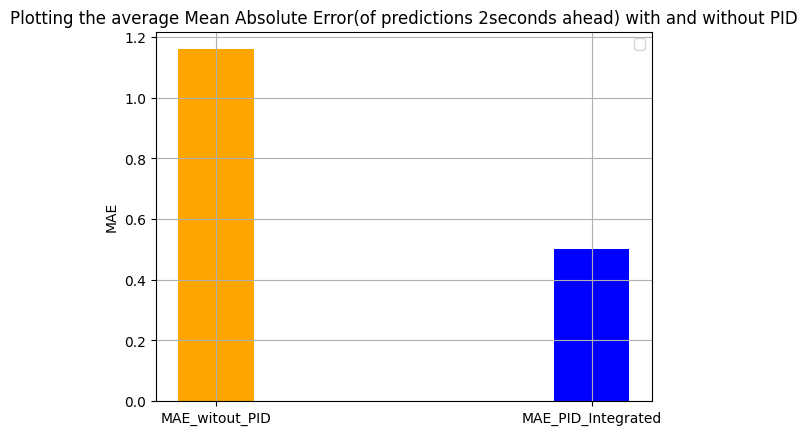

In [117]:
values = {'MAE_witout_PID': mae_test_LSTM, 'MAE_PID_Integrated': mae_test_LSTM_new}
colors = ['orange', 'blue']
bar_width = 0.2

# Plotting
plt.bar(values.keys(), values.values(), color=colors, width=bar_width)
x_pos = list(range(len(values)))

# Adding labels and title
plt.ylabel('MAE')
plt.title('Plotting the average Mean Absolute Error(of predictions 2seconds ahead) with and without PID')
plt.xticks(x_pos, values.keys())
plt.legend()
plt.grid(True)
# Showing the plot
plt.show()